# Using `pandas` with `dataframe-haystack`

In [1]:
# when running in Google Colab, install the following packages
# !pip install 'dataframe-haystack[polars]' arxiv

In [2]:
import polars as pl

## Downloading the dataset

We are using a dataset that contains abstracts of papers uploaded on arXiv. We are using the arXiv API to get the data.

In [3]:
def get_arxiv_data(search_query: str, max_num_rows: int = 10) -> pl.DataFrame:
    """Get data using the arXiv API."""
    import arxiv

    arxiv_client = arxiv.Client()

    search = arxiv.Search(query=search_query, max_results=max_num_rows, sort_by=arxiv.SortCriterion.Relevance)
    results_list = [
        {
            "title": result.title,
            "authors": [author.name for author in result.authors],
            "summary": result.summary,
            "published": result.published,
            "primary_category": result.primary_category,
            "categories": result.categories,
            "pdf_url": result.pdf_url,
            "entry_id": result.entry_id,
        }
        for result in arxiv_client.results(search)
    ]
    return pl.DataFrame(results_list)

We will have a dataset of 10 rows with papers about LLMs.

In [4]:
df = get_arxiv_data("llm", max_num_rows=10)
df.head()

title,authors,summary,published,primary_category,categories,pdf_url,entry_id
str,list[str],str,datetime[μs],str,list[str],str,str
"""A Survey of La…","[""Zibin Zheng"", ""Kaiwen Ning"", … ""Jiachi Chen""]","""General large …",2023-11-17 07:55:16,"""cs.SE""","[""cs.SE""]","""http://arxiv.o…","""http://arxiv.o…"
"""TEST: Text Pro…","[""Chenxi Sun"", ""Hongyan Li"", … ""Shenda Hong""]","""This work summ…",2023-08-16 09:16:02,"""cs.CL""","[""cs.CL"", ""cs.AI""]","""http://arxiv.o…","""http://arxiv.o…"
"""Benchmarking L…","[""Fanghua Ye"", ""Mingming Yang"", … ""Zhaopeng Tu""]","""The proliferat…",2024-01-23 14:29:17,"""cs.CL""","[""cs.CL""]","""http://arxiv.o…","""http://arxiv.o…"
"""Is LLM-as-a-Ju…","[""Vyas Raina"", ""Adian Liusie"", ""Mark Gales""]","""Large Language…",2024-02-21 18:55:20,"""cs.CL""","[""cs.CL""]","""http://arxiv.o…","""http://arxiv.o…"
"""MEGAnno+: A Hu…","[""Hannah Kim"", ""Kushan Mitra"", … ""Dan Zhang""]","""Large language…",2024-02-28 04:58:07,"""cs.CL""","[""cs.CL"", ""cs.HC""]","""http://arxiv.o…","""http://arxiv.o…"


## Loading the data in `haystack`

In [5]:
from dataframes_haystack.components.converters.polars import PolarsDataFrameConverter

In [6]:
polars_converter = PolarsDataFrameConverter(
    content_column="summary",
    meta_columns=["title", "authors", "published", "primary_category", "categories", "pdf_url"],
)

In [7]:
polars_converter.run(dataframe=df)

{'documents': [Document(id=2702154691a919112848f4dde5e22d7ef687c3ef52b259fa35e4688bda71ecba, content: 'General large language models (LLMs), represented by ChatGPT, have
  demonstrated significant potentia...', meta: {'title': 'A Survey of Large Language Models for Code: Evolution, Benchmarking, and Future Trends', 'authors': ['Zibin Zheng', 'Kaiwen Ning', 'Yanlin Wang', 'Jingwen Zhang', 'Dewu Zheng', 'Mingxi Ye', 'Jiachi Chen'], 'published': datetime.datetime(2023, 11, 17, 7, 55, 16), 'primary_category': 'cs.SE', 'categories': ['cs.SE'], 'pdf_url': 'http://arxiv.org/pdf/2311.10372v2'}),
  Document(id=35967fa7acbb9084391de4d3d211ca12da8a3688e599b3039f077735fc946ea7, content: 'This work summarizes two ways to accomplish Time-Series (TS) tasks in today's
  Large Language Model (...', meta: {'title': "TEST: Text Prototype Aligned Embedding to Activate LLM's Ability for Time Series", 'authors': ['Chenxi Sun', 'Hongyan Li', 'Yaliang Li', 'Shenda Hong'], 'published': datetime.datetime(2023, 

If we want to use a column of the dataframe as unique identifier for documents, we can set the `index_column` parameter.

In [8]:
polars_converter = PolarsDataFrameConverter(
    content_column="summary",
    meta_columns=["title", "authors", "published", "primary_category", "categories", "pdf_url"],
    index_column="entry_id",
)
polars_converter.run(dataframe=df)

{'documents': [Document(id=http://arxiv.org/abs/2311.10372v2, content: 'General large language models (LLMs), represented by ChatGPT, have
  demonstrated significant potentia...', meta: {'title': 'A Survey of Large Language Models for Code: Evolution, Benchmarking, and Future Trends', 'authors': ['Zibin Zheng', 'Kaiwen Ning', 'Yanlin Wang', 'Jingwen Zhang', 'Dewu Zheng', 'Mingxi Ye', 'Jiachi Chen'], 'published': datetime.datetime(2023, 11, 17, 7, 55, 16), 'primary_category': 'cs.SE', 'categories': ['cs.SE'], 'pdf_url': 'http://arxiv.org/pdf/2311.10372v2'}),
  Document(id=http://arxiv.org/abs/2308.08241v2, content: 'This work summarizes two ways to accomplish Time-Series (TS) tasks in today's
  Large Language Model (...', meta: {'title': "TEST: Text Prototype Aligned Embedding to Activate LLM's Ability for Time Series", 'authors': ['Chenxi Sun', 'Hongyan Li', 'Yaliang Li', 'Shenda Hong'], 'published': datetime.datetime(2023, 8, 16, 9, 16, 2), 'primary_category': 'cs.CL', 'categories': [

### Using the `PolarsDataFrameConverter` in a pipeline

In [9]:
from haystack import Pipeline
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

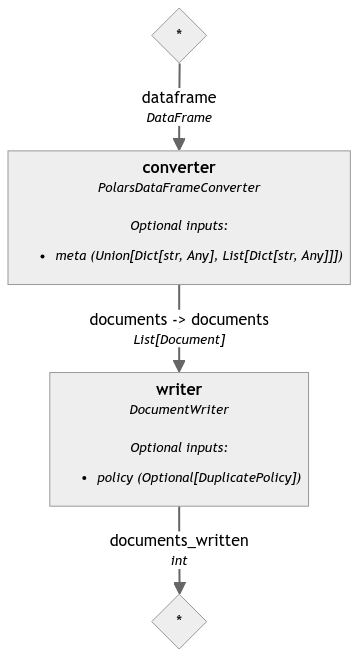

In [10]:
document_store = InMemoryDocumentStore()

indexing = Pipeline()
indexing.add_component(
    "converter",
    PolarsDataFrameConverter(
        content_column="summary",
        meta_columns=["title", "authors", "published", "primary_category", "categories", "pdf_url"],
    ),
)
indexing.add_component("writer", DocumentWriter(document_store))
indexing.connect("converter", "writer")
indexing.show()

In [11]:
indexing.run({"converter": {"dataframe": df}})

{'writer': {'documents_written': 10}}